# ACCESS salinity in AABW formation regions

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43497,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:35673,Total threads: 1
Dashboard: /proxy/33755/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45769,


2025-10-07 18:57:56,125 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-e60bbd36f217be558c5db0db248afcc7', 2, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('getitem-e60bbd36f217be558c5db0db248afcc7', 2, 2) getitem(...)>
new run_spec: Alias(('getitem-e60bbd36f217be558c5db0db248afcc7', 2, 2)->('concatenate-rechunk-merge-rechunk-split-getitem-e60bbd36f217be558c5db0db248afcc7', 2, 2))
old dependencies: {('getitem-3433de4943fd434b45aa300de8ce503b', 0, 2, 2)}
new dependencies: {('concatenate-rechunk-merge-rechunk-split-getitem-e60bbd36f217be558c5db0db248afcc7', 2, 2)}



In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds['salt'].isel(st_ocean=0).where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
#Time invariant variables
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']

In [10]:
# Salinity variable
saltC = cont['salt']
saltM = melt['salt']

In [12]:
# Correcting area
area_corr = area*(saltC.isel(time=0)*0 +1)

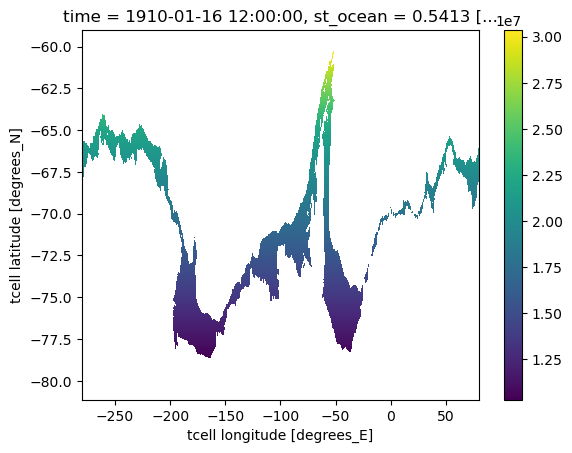

In [13]:
# Checking area and shelf mask
area_corr.plot()

### Creating the regions

In [14]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

Adelie = slice(AdelieW,AdelieE)
Ross = slice(RossW, RossE)
Am = slice(AmW, AmE)
Be = slice(BeW,BeE)
Weddell = slice(WeddellW, WeddellE)
Prydz = slice(PrydzW, PrydzE)

In [15]:
area_Adelie = area_corr.sel(xt_ocean=Adelie).where(shelf_mask == 1)
area_Ross = area_corr.sel(xt_ocean=Ross).where(shelf_mask == 1)
area_Am = area_corr.sel(xt_ocean=Am).where(shelf_mask == 1)
area_Be = area_corr.sel(xt_ocean=Be).where(shelf_mask == 1)
area_Weddell = area_corr.sel(xt_ocean=Weddell).where(shelf_mask == 1)
area_Prydz = area_corr.sel(xt_ocean=Prydz).where(shelf_mask == 1)

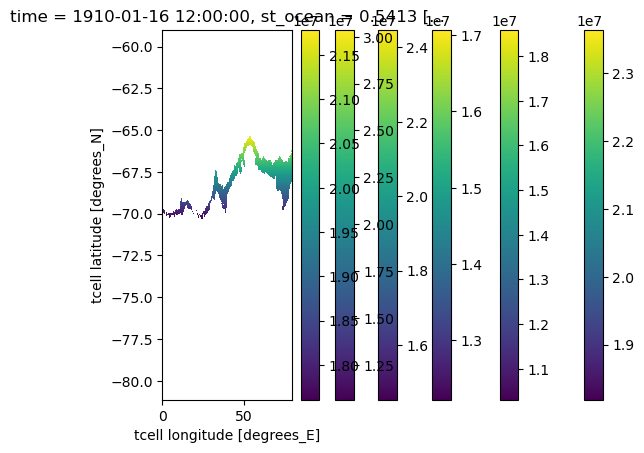

In [16]:
area_Adelie.plot()
area_Ross.plot()
area_Am.plot()
area_Be.plot()
area_Weddell.plot()
area_Prydz.plot()

### Bottom mask

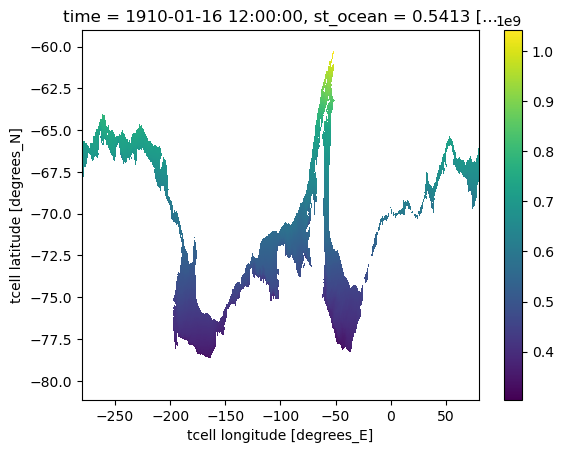

In [17]:
# Checking mask
(area_corr * saltC.isel(time=0)).plot()

### Time series

In [18]:
# Restricting to regions # surface salt but haven't renamed
botsalt_cont_1 = saltC.sel(xt_ocean=Adelie)
botsalt_pert_1 = saltM.sel(xt_ocean=Adelie)

botsalt_cont_2 = saltC.sel(xt_ocean=Ross)
botsalt_pert_2 = saltM.sel(xt_ocean=Ross)

botsalt_cont_3 = saltC.sel(xt_ocean=Am)
botsalt_pert_3 = saltM.sel(xt_ocean=Am)

botsalt_cont_4 = saltC.sel(xt_ocean=Be)
botsalt_pert_4 = saltM.sel(xt_ocean=Be)

botsalt_cont_5 = saltC.sel(xt_ocean=Weddell)
botsalt_pert_5 = saltM.sel(xt_ocean=Weddell)

botsalt_cont_6 = saltC.sel(xt_ocean=Prydz)
botsalt_pert_6 = saltM.sel(xt_ocean=Prydz)

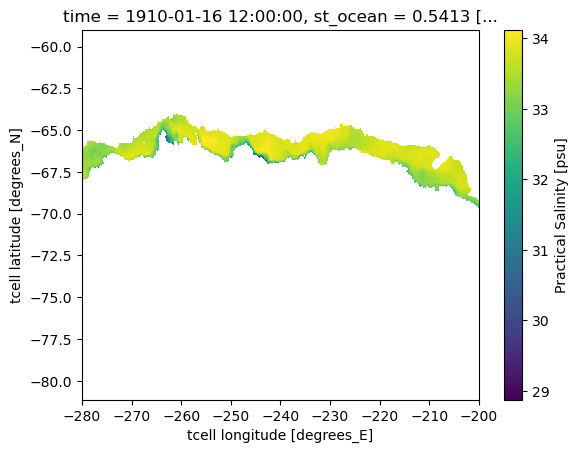

In [19]:
botsalt_cont_1.isel(time=0).plot()

In [20]:
# Spatial averages
botsalt_cont_1_time = (area_corr * botsalt_cont_1).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Adelie).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_1_time = (area_corr * botsalt_pert_1).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Adelie).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_2_time = (area_corr * botsalt_cont_2).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Ross).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_2_time = (area_corr * botsalt_pert_2).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Ross).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_3_time = (area_corr * botsalt_cont_3).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Am).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_3_time = (area_corr * botsalt_pert_3).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Am).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_4_time = (area_corr * botsalt_cont_4).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Be).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_4_time = (area_corr * botsalt_pert_4).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Be).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_5_time = (area_corr * botsalt_cont_5).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Weddell).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_5_time = (area_corr * botsalt_pert_5).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Weddell).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_6_time = (area_corr * botsalt_cont_6).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Prydz).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_6_time = (area_corr * botsalt_pert_6).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Prydz).sum(['xt_ocean', 'yt_ocean'])


In [21]:
# Check shape
botsalt_cont_1_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00
    st_ocean  float64 8B 0.5413

In [22]:
botsalt_cont_1_time = botsalt_cont_1_time.load()
botsalt_pert_1_time = botsalt_pert_1_time.load()

In [23]:
botsalt_cont_2_time = botsalt_cont_2_time.load()
botsalt_pert_2_time = botsalt_pert_2_time.load()

In [24]:
botsalt_cont_3_time = botsalt_cont_3_time.load()
botsalt_pert_3_time = botsalt_pert_3_time.load()

In [25]:
botsalt_cont_4_time = botsalt_cont_4_time.load()
botsalt_pert_4_time = botsalt_pert_4_time.load()

In [26]:
botsalt_cont_5_time = botsalt_cont_5_time.load()
botsalt_pert_5_time = botsalt_pert_5_time.load()

In [27]:
botsalt_cont_6_time = botsalt_cont_6_time.load()
botsalt_pert_6_time = botsalt_pert_6_time.load()

In [28]:
botsalt_anom_1_time = botsalt_pert_1_time - botsalt_cont_1_time
botsalt_anom_1_time = botsalt_anom_1_time.load()
botsalt_anom_1_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Adelie_prescribed_access.nc')

In [29]:
botsalt_anom_2_time = botsalt_pert_2_time - botsalt_cont_2_time
botsalt_anom_2_time = botsalt_anom_2_time.load()
botsalt_anom_2_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Ross_prescribed_access.nc')

In [30]:
botsalt_anom_3_time = botsalt_pert_3_time - botsalt_cont_3_time
botsalt_anom_3_time = botsalt_anom_3_time.load()
botsalt_anom_3_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Am_prescribed_access.nc')

In [31]:
botsalt_anom_4_time = botsalt_pert_4_time - botsalt_cont_4_time
botsalt_anom_4_time = botsalt_anom_4_time.load()
botsalt_anom_4_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Be_prescribed_access.nc')

In [32]:
botsalt_anom_5_time = botsalt_pert_5_time - botsalt_cont_5_time
botsalt_anom_5_time = botsalt_anom_5_time.load()
botsalt_anom_5_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Weddell_prescribed_access.nc')

In [33]:
botsalt_anom_6_time = botsalt_pert_6_time - botsalt_cont_6_time
botsalt_anom_6_time = botsalt_anom_6_time.load()
botsalt_anom_6_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_Prydz_prescribed_access.nc')

#### Plotting all

Text(0.5, 1.0, 'ACCESS (prescribed) Surface Salinity on Shelf, formation regions')

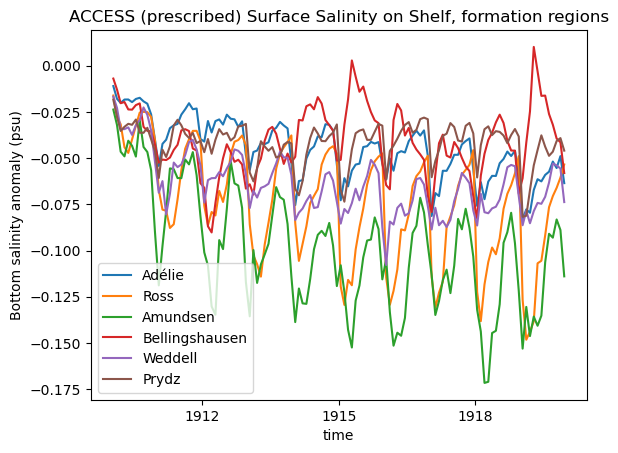

In [34]:
botsalt_anom_1_time.plot(label="Adélie")
botsalt_anom_2_time.plot(label="Ross")
botsalt_anom_3_time.plot(label="Amundsen")
botsalt_anom_4_time.plot(label="Bellingshausen")
botsalt_anom_5_time.plot(label="Weddell")
botsalt_anom_6_time.plot(label="Prydz")
plt.ylabel("Bottom salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("ACCESS (prescribed) Surface Salinity on Shelf, formation regions")
